In [1]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from copy import deepcopy
from ax import optimize
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.trace import optimization_trace_single_method


from concurrent_functions import get_q2_concurrent, calculate_q2_for_combination
plt.rcParams["font.family"] = "Times New Roman"

import torch
mps_device = torch.device("mps")

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Get Key Files

### Full Multi-Task Data
Here, there is one row per stage. Each row explains how a particular team did on a particular task with a particular complexity.

### Task Map

In [3]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [4]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole"
}

In [5]:
GROUPING_COLS = ["task_name", "complexity", "playerCount"]

In [6]:
# Let's use the Permutation Data as the ground truth for all models here
permutation_data = pd.read_csv("./task_map_explorations_with_multitask/permutation_data.csv")
permutation_data.loc[:, "task"] = permutation_data["task"].replace(task_name_mapping)
permutation_data = permutation_data.rename(columns={"task": "task_name"})

In [7]:
with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)
	
stage_based_data.data.loc[:, "task_name"] = stage_based_data.data["task"].replace(task_name_mapping)
comms_features = stage_based_data.data.groupby(GROUPING_COLS)[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]].agg("mean").reset_index()
overlapping_columns = set(comms_features.columns).intersection(permutation_data.columns)
comms_features = comms_features.drop(list(overlapping_columns), axis = 1)
grouped_performance_with_task_cols = pd.concat([permutation_data,comms_features], axis = 1)

In [8]:
grouped_performance_with_task_cols = pd.merge(left = grouped_performance_with_task_cols, right = task_map, on = "task_name", how = "left")

In [9]:
# focus on only the strong synergy DV
grouped_performance_with_task_cols = grouped_performance_with_task_cols.rename(columns={"strong": "synergy"}).drop("weak", axis = 1)

In [10]:
# sort by task name and then playerCount, ensuring a specific dataframe set-up
grouped_performance_with_task_cols = grouped_performance_with_task_cols.sort_values(["task_name", "High", "Medium"])

## Recreation of PCA Plot (Figure 4) with Real Data

In [11]:
task_cols_to_use = task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis = 1).columns

In [12]:
numeric_columns = [col for col in grouped_performance_with_task_cols.columns if (grouped_performance_with_task_cols[col].dtype == "int64" or grouped_performance_with_task_cols[col].dtype == "float64")]

In [13]:
grouped_avg_all_tasks = grouped_performance_with_task_cols.groupby("task_name")[numeric_columns].agg("mean").reset_index()

In [14]:
# Normalize task columns
normalized_df = grouped_avg_all_tasks.copy()
normalized_df[task_cols_to_use] = normalized_df[task_cols_to_use].transform(lambda x: (x - x.mean()) / x.std())

pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(normalized_df[task_cols_to_use])

In [15]:
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

In [16]:
# dependent variables of interest
pca_df["synergy"] = grouped_avg_all_tasks["synergy"]
pca_df["gini_coefficient"] = grouped_avg_all_tasks["gini_coefficient_sum_num_messages"]
pca_df["total_words"] = grouped_avg_all_tasks["sum_num_words"]
pca_df["average_positivity"] = grouped_avg_all_tasks["average_positive_bert"]

# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

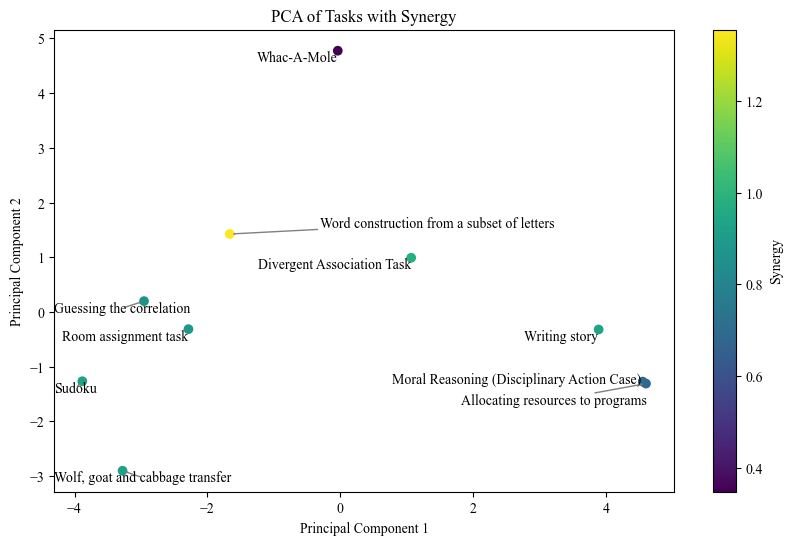

In [102]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.grid(False)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "synergy", dv_label="Synergy")

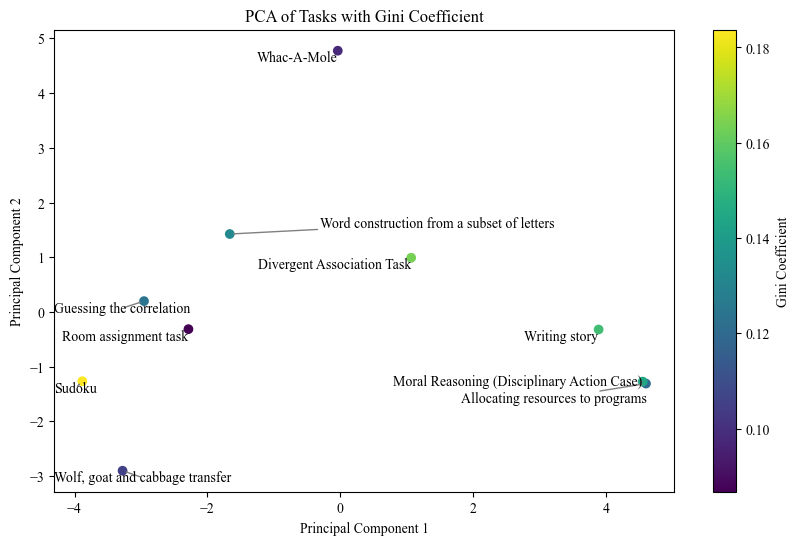

In [103]:
plot_pca_scatter_with_labels(pca_df, dv = "gini_coefficient", dv_label="Gini Coefficient")

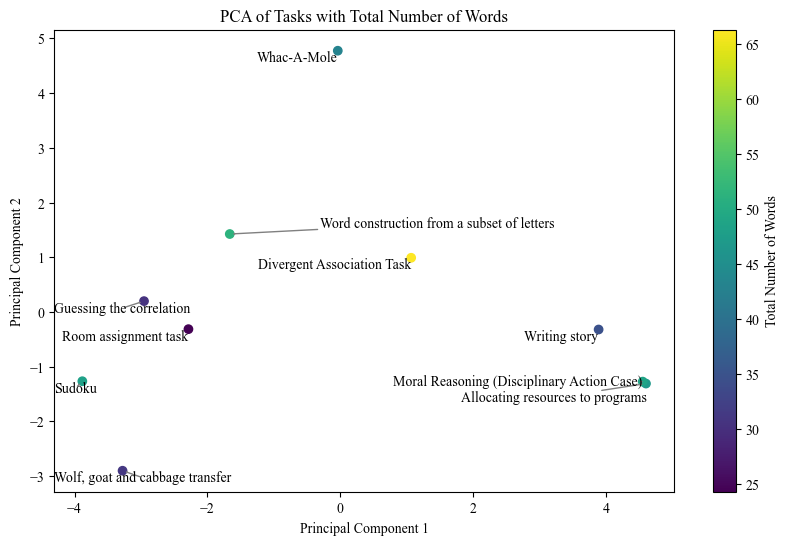

In [104]:
plot_pca_scatter_with_labels(pca_df, dv = "total_words", dv_label="Total Number of Words")

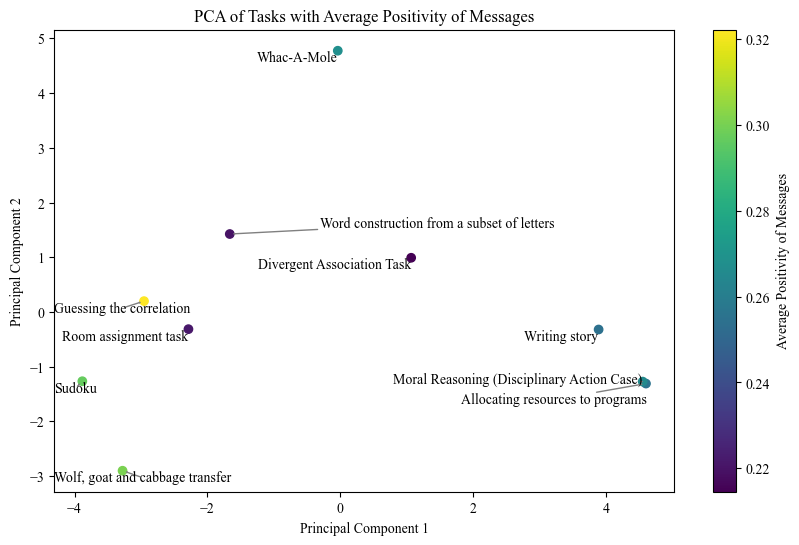

In [105]:
plot_pca_scatter_with_labels(pca_df, dv = "average_positivity", dv_label="Average Positivity of Messages")

In [21]:
# explore how DV's with different features
correlation_values = []

for colname in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
    correlation = np.corrcoef(grouped_performance_with_task_cols[colname], grouped_performance_with_task_cols["synergy"])[0][1]
    correlation_values.append((colname, correlation))

# Sort the correlation values in descending order based on the correlation coefficient
sorted_correlation_values = sorted(correlation_values, key=lambda x: x[1], reverse=True)

# Print the sorted correlation values
sorted_correlation_values

[('Q4type_2_generate', 0.6627923041114272),
 ('Q19time_solvability', 0.5155695006493212),
 ('Q9divisible_unitary', 0.4970740684892798),
 ('Q17within_sys_sol', 0.485642636482031),
 ('Q15dec_verifiability', 0.4847702822987075),
 ('Q5creativity_input_1', 0.4666559611310893),
 ('Q18ans_recog', 0.405577589803303),
 ('Q20type_3_type_4', 0.3797678996047656),
 ('Q16shared_knowledge', 0.28410559775138544),
 ('Q21intellective_judg_1', 0.27022449668552884),
 ('Q13outcome_multip', 0.24402658666495167),
 ('Q11optimizing', 0.1897957104177961),
 ('Q10maximizing', 0.15031394583022809),
 ('Q3type_1_planning', 0.1468843734931336),
 ('Q8type_8_performance', 0.121408805664267),
 ('Q7type_7_battle', 0.11594313941615343),
 ('Q24eureka_question', 0.07761609097605293),
 ('Q14sol_scheme_mul', -0.16154864181800627),
 ('Q23ss_out_uncert', -0.16968065332443003),
 ('Q6type_5_cc', -0.30289776838666777),
 ('Q22confl_tradeoffs', -0.4345321591596464),
 ('Q2intel_manip_1', -0.6075738321505416),
 ('Q1concept_behav', -0.

In [22]:
task_cols = task_map.drop("task_name", axis = 1).columns

In [23]:
def plot_q2_heatmap(q2_matrix, y_cols, feature_name):
    q2_matrix = np.array(q2_matrix)  # Ensure correlation_matrix is a NumPy array
    average_values = np.mean(q2_matrix, axis=0)
    # average_abs_values = np.mean(np.abs(q2_matrix), axis=0)
    mapping = {idx: value for idx, value in enumerate(average_values)}
    sorted_mapping = sorted(mapping.items(), key=lambda x: x[1], reverse=True)
    sorted_q2_matrix = q2_matrix[:, [idx for idx, _ in sorted_mapping]]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(sorted_q2_matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(task_cols)))
    ax.set_xticklabels(task_cols, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(y_cols)), labels=y_cols)

    ax.set_title("Q^2 for Single Variate Between " + feature_name + " & Task Feature")

    # Add shorter and horizontal colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink = 0.6)
    cbar.set_label('Q^2')

    for i in range(sorted_q2_matrix.shape[0]):
        for j in range(sorted_q2_matrix.shape[1]):
            value = sorted_q2_matrix[i][j]
            color = 'black' if value >= 0 else 'red'
            ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=color, fontsize=12)

    fig.tight_layout()
    plt.show()

In [44]:
def generate_task_index(X_without_task_labels, num_cats = 10):
    # when we pass in X for the q2 calculation, we do not have the task labels
    # so, let's add in an index for each group of rows (which are part of the same task)

    num_rows = len(X_without_task_labels)
    num_rows_in_group = num_rows / num_cats # there are 10 tasks; there are 30 task instances (adding low/med/high)
    num_groups = (num_rows + num_rows_in_group - 1) // num_rows_in_group  # Calculate the number of groups
    key_values = np.repeat(np.arange(num_groups), num_rows_in_group)[:num_rows]  # Generate key values for each group
    df = X_without_task_labels.copy()
    df['task_index'] = key_values

    return df

In [45]:
def reshape_x_y(x, y):
    if(isinstance(x, pd.Series)):
        x = np.asarray(x).reshape(-1, 1)
    else:
        x = np.asarray(x)
    
    y = np.asarray(y).reshape(-1, 1)
    return(x, y)

In [26]:
def q2_task_holdout_helper(x_train, x_test, y_train, y_test, estimator):

    # some reshaping
    x_train_array, y_train_array = reshape_x_y(x_train, y_train)
    x_test_array, y_test_array = reshape_x_y(x_test, y_test)

    # Fit the model and get the error
    fitted_model = estimator.fit(X=x_train_array, y=y_train_array.ravel())
    
    # save prediction error
    prediction = fitted_model.predict(x_test_array)[0]
    squared_model_prediction_error = (y_test_array - prediction) ** 2

    # save total error for this fold
    squared_average_prediction_error = (y_test_array - np.mean(y_train_array)) ** 2

    return squared_model_prediction_error, squared_average_prediction_error

In [46]:
"""
This is the version of q^2 that holds out EVERYTHING associated with a given task

It trains on all task instances from the "seen" classes, and it tests on task instances of held-out (unseen) classes.

@param unit = {"task", "instance"}; if "task", we hold out an entire task class; if "instance," we hold out a complexity level of a task (a true "instance")
"""
def get_q2(y, x, estimator = LinearRegression(), num_task_holdouts = 1, N_TASK_SAMPLES = 100, unit = "task"):

    # define the unit of analysis
    if unit == "task":
        num_cats = 10
    elif unit == "instance":
        num_cats = 30

    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    # generate an index for x and y
    x = generate_task_index(pd.DataFrame(x), num_cats = num_cats)
    y = generate_task_index(pd.DataFrame(y), num_cats = num_cats)

    num_total_tasks = len(set(x['task_index'].values))

    for i in range(num_total_tasks):        
        # randomly hold out `num_task_holdouts`
        all_possible_task_combos = list(itertools.combinations(set(x['task_index'].values), num_total_tasks - num_task_holdouts))
        task_samples = random.choices(all_possible_task_combos, k=N_TASK_SAMPLES)
        
        for sample in task_samples:
            x_train_tasks = x[x["task_index"].isin(sample)].drop('task_index', axis = 1)
            x_test_tasks = x[~x["task_index"].isin(sample)].drop('task_index', axis = 1)

            y_train_tasks = y[y["task_index"].isin(sample)].drop('task_index', axis = 1)
            y_test_tasks = y[~y["task_index"].isin(sample)].drop('task_index', axis = 1)

            # get evaluation score by training on the training tasks and evaluating on the holdout tasks
            squared_model_prediction_error, squared_average_prediction_error = q2_task_holdout_helper(x_train_tasks, x_test_tasks, y_train_tasks, y_test_tasks, estimator)

            squared_model_prediction_errors.append(squared_model_prediction_error)
            squared_average_prediction_errors.append(squared_average_prediction_error)

    return 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))

>  heatmap with x task features and y outcome (synegy, gini) and avging over task complexity.. x axis ordered by avg q^2 across outcomes

## Leaving out an entire TASK

In [47]:
q_2_for_all_dvs_task = []
dvs = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use:
        # get the q2 for each
       
        # this is for leaving out an entire TASK
        q2 = get_q2(grouped_performance_with_task_cols[dv], grouped_performance_with_task_cols[col])

        within_dv_arr.append(q2)

    q_2_for_all_dvs_task.append(within_dv_arr)

In [48]:
q2_by_dv_df_task = pd.DataFrame(q_2_for_all_dvs_task, columns=task_cols_to_use, index = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"])
# sort by average
q2_by_dv_df_task = q2_by_dv_df_task.reindex(q2_by_dv_df_task.mean().sort_values(ascending=False).index, axis=1)

In [49]:
q2_by_dv_df_task#.to_csv("./task_map_explorations_with_multitask/q2_by_dv_df_task.csv")

,Q4type_2_generate,Q19time_solvability,Q17within_sys_sol,Q15dec_verifiability,Q20type_3_type_4,Q22confl_tradeoffs,Q18ans_recog,Q5creativity_input_1,Q6type_5_cc,Q21intellective_judg_1,...,Q11optimizing,Q8type_8_performance,Q23ss_out_uncert,Q3type_1_planning,Q7type_7_battle,Q24eureka_question,Q10maximizing,Q9divisible_unitary,Q2intel_manip_1,Q1concept_behav
synergy,0.287694,0.140705,0.104769,0.137407,0.085035,0.099116,0.069182,0.013754,0.002202,-0.031203,...,-0.141211,-0.047636,-0.086092,-0.109652,-0.271298,-0.048220,-0.767046,-1.761298,-2.268690,-0.221529
gini_coefficient_sum_num_messages,-0.025337,-0.038468,-0.061125,-0.041666,-0.036236,-0.020262,-0.047113,-0.020379,-0.027239,-0.022274,...,-0.083517,-0.144804,-0.101299,0.009823,-0.016414,-0.080454,-0.001690,-0.298337,-0.509905,-15.038785
average_positive_bert,0.076389,-0.035497,0.003888,-0.032606,-0.019802,-0.044658,-0.018657,0.009355,-0.020585,-0.024952,...,0.030006,0.025950,0.049006,-0.149985,-0.015155,-0.313751,-0.002561,0.028277,-0.012927,-3.530564
sum_num_words,0.033340,-0.008586,0.000024,-0.017078,0.001527,-0.038521,-0.015062,-0.058429,-0.013354,-0.017511,...,-0.004572,-0.049305,-0.091980,0.002207,-0.015756,-0.088111,-0.016396,-0.271058,-0.256947,-0.904678


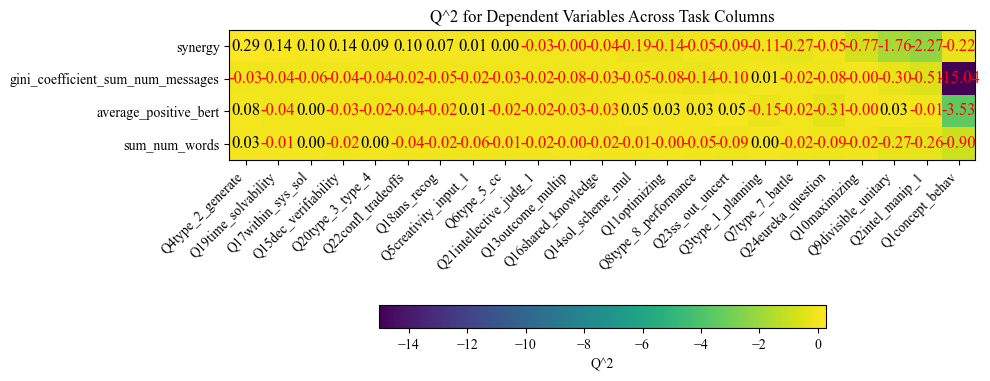

In [50]:
def plot_q2_across_dvs(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(df, cmap='viridis')  # Set your preferred colormap

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(dvs)))
    ax.set_yticklabels(dvs)

    # Loop over data dimensions and create text annotations
    for i in range(len(dvs)):
        for j in range(len(df.columns)):
            value = df.iloc[i, j]
            color = 'black' if value >= 0 else 'red'
            ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=color, fontsize=12)  # Adjust fontsize as needed

    ax.set_title("Q^2 for Dependent Variables Across Task Columns")

    # Add shorter and horizontal colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink=0.6)
    cbar.set_label('Q^2')

    fig.tight_layout()
    plt.show()

plot_q2_across_dvs(q2_by_dv_df_task)

## Leaving out only a TASK INSTANCE

In [51]:
q_2_for_all_dvs_instance = []
dvs = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use:
        # get the q2 for each
       
        # this is for leaving out a TASK INSTANCE
        q2 = get_q2(grouped_performance_with_task_cols[dv], grouped_performance_with_task_cols[col], unit="instance")

        within_dv_arr.append(q2)

    q_2_for_all_dvs_instance.append(within_dv_arr)

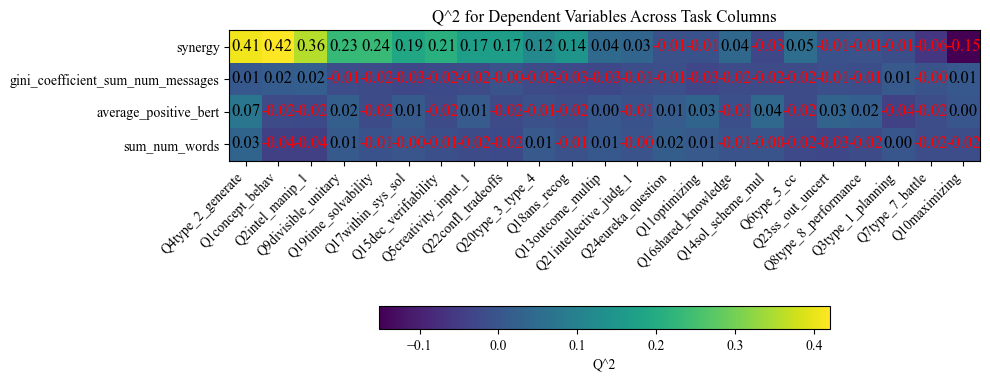

In [53]:
q2_by_dv_df_instance = pd.DataFrame(q_2_for_all_dvs_instance, columns=task_cols_to_use, index = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"])
q2_by_dv_df_instance = q2_by_dv_df_instance.reindex(q2_by_dv_df_instance.mean().sort_values(ascending=False).index, axis=1)
plot_q2_across_dvs(q2_by_dv_df_instance)

In [54]:
q2_by_dv_df_instance#.to_csv("./task_map_explorations_with_multitask/q2_by_dv_df_instance.csv")

,Q4type_2_generate,Q1concept_behav,Q2intel_manip_1,Q9divisible_unitary,Q19time_solvability,Q17within_sys_sol,Q15dec_verifiability,Q5creativity_input_1,Q22confl_tradeoffs,Q20type_3_type_4,...,Q24eureka_question,Q11optimizing,Q16shared_knowledge,Q14sol_scheme_mul,Q6type_5_cc,Q23ss_out_uncert,Q8type_8_performance,Q3type_1_planning,Q7type_7_battle,Q10maximizing
synergy,0.408170,0.419891,0.356625,0.231942,0.236452,0.191834,0.210401,0.169376,0.169899,0.116935,...,-0.009649,-0.006159,0.040397,-0.028174,0.052415,-0.007312,-0.005452,-0.014604,-0.061347,-0.150821
gini_coefficient_sum_num_messages,0.006387,0.015451,0.018873,-0.014846,-0.021205,-0.027085,-0.021989,-0.019911,-0.004177,-0.017918,...,-0.011840,-0.030200,-0.018875,-0.020626,-0.019625,-0.011358,-0.014166,0.008092,-0.004535,0.005637
average_positive_bert,0.073356,-0.020550,-0.023209,0.022111,-0.018104,0.010103,-0.019788,0.013101,-0.020926,-0.008143,...,0.013788,0.033762,-0.011024,0.041004,-0.020925,0.030404,0.019923,-0.038669,-0.016360,0.001818
sum_num_words,0.032673,-0.042356,-0.043089,0.010524,-0.006081,-0.000955,-0.010825,-0.017874,-0.023354,0.007489,...,0.018157,0.008426,-0.005664,-0.003446,-0.024028,-0.027563,-0.020102,0.002037,-0.016927,-0.016340


## Q^2 of Regressions with Different Numbers of features
x-axis --> number of features of the task space included
y-axis --> Q^2

i.e.
x=1; y= avg(Q^2) across all features because you fit
x=2; y = Q^2 of a model with two features.. avg over all pairs of features…
etc

### Different versions of features, selecting the "best" feature 1 at a time

In [56]:
def top_n_q2_for_index(index, n, type):
    if type == "class":
        q2_by_dv_df = q2_by_dv_df_task
    elif type == "instance":
        q2_by_dv_df = q2_by_dv_df_instance
    else:
        raise ValueError("type must be one of class or instance.")

    top_columns = q2_by_dv_df.loc[index].nlargest(n).index.tolist()
    return top_columns

In [57]:
if("complexity" in GROUPING_COLS and "playerCount" in GROUPING_COLS):

    dvs = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
    dv_output_dict_best = {}
    dv_output_dict_best_instance = {}

    for i, dv in enumerate(dvs):
        dv_output_dict_best[dv] = []
        dv_output_dict_best_instance[dv] = []

        for num_features in range(1, len(task_cols_to_use)+1):
            print("Now running models for " + str(num_features) + " features...")
            
            # select the best model by choosing the top features in terms of univariate q^2
            
            # DV is by TASK CLASS
            top_features_class = top_n_q2_for_index(dv, num_features, type = "class")
            q2_class = get_q2(grouped_performance_with_task_cols[dv], grouped_performance_with_task_cols[top_features_class + ["playerCount", "Low", "Medium"]]) # also control for the playerCount and complexity in the model
            dv_output_dict_best[dv].append(q2_class)

            # DV is by TASK INSTANCE
            top_features_instance = top_n_q2_for_index(dv, num_features, type = "instance")
            q2_instance = get_q2(grouped_performance_with_task_cols[dv], grouped_performance_with_task_cols[top_features_instance + ["playerCount", "Low", "Medium"]], unit = "instance") # also control for the playerCount and complexity in the model
            dv_output_dict_best_instance[dv].append(q2_instance)

Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4 features...
Now running models for 5 features...
Now running models for 6 features...
Now running models for 7 features...
Now running models for 8 features...
Now running models for 9 features...
Now running models for 10 features...
Now running models for 11 features...
Now running models for 12 features...
Now running models for 13 features...
Now running models for 14 features...
Now running models for 15 features...
Now running models for 16 features...
Now running models for 17 features...
Now running models for 18 features...
Now running models for 19 features...
Now running models for 20 features...
Now running models for 21 features...
Now running models for 22 features...
Now running models for 23 features...
Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4

In [58]:
def plot_q2_by_number_of_features(df_q2_means_for_feature, title):
    fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

    # Store colors for each DV
    dv_colors = {}

    width = 0.16  # the width of the bars
    multiplier = 0

    for dv in df_q2_means_for_feature.columns:
        means_for_key = df_q2_means_for_feature[dv]
        # stds_for_key = df_q2_stds_for_feature[dv]
        # offset = width * multiplier
        # offset_back = (0.16) * 2.5
        # line plot version
        line, = ax.plot(np.arange(1, 24), means_for_key, label=f'{dv}')
        dv_colors[dv] = line.get_color()  # Store the color for this DV

        # bar plot version
        # rects = ax.bar(np.arange(1, 24) + offset - offset_back, means_for_key, width, label=f'{dv}')
        for i in range(1, 24):
            x = i # + offset - offset_back
            y = means_for_key[i-1]
            # std = stds_for_key[i-1]
            # ax.errorbar(x, y, std, color="black")
        multiplier += 1

    # Adding horizontal gray line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

    # Add horizontal lines for "optimal" model performance for each DV
    # TODO --- this needs to be adjusted based on the optimality of task class LOO versus task instance LOO
    # for dv in df_q2_means_for_feature.columns:
    #     optimal_df = pd.DataFrame(optimal_dict)
    #     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
    #     best_perf = np.max(performance_for_dv["optimal_q2"])
    #     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

    # ax.set_ylim(-4, 4)
    ax.legend(fontsize=14, loc='lower right')
    plt.xticks(ticks=[_ for _ in range(1, 24)], fontsize=24)
    plt.yticks(fontsize=24)

    plt.xlabel('Number of Task Features Included', fontsize=24)
    plt.ylabel('Q^2', fontsize=24)

    plt.title(title, fontsize = 24)

In [59]:
# for TASK CLASS
df_q2_means_for_feature = pd.DataFrame()
for key in dv_output_dict_best.keys():
    means = [np.mean(sublist) for sublist in dv_output_dict_best[key]]
    df_q2_means_for_feature[key] = means

# for TASK INSTANCE
df_q2_means_for_feature_instance = pd.DataFrame()
for key in dv_output_dict_best_instance.keys():
    means = [np.mean(sublist) for sublist in dv_output_dict_best_instance[key]]
    df_q2_means_for_feature_instance[key] = means

# df_q2_stds_for_feature = pd.DataFrame()
# for key in dv_output_dict_best.keys():
#     std = [np.std(sublist) for sublist in dv_output_dict_best[key]]
#     df_q2_stds_for_feature[key] = std

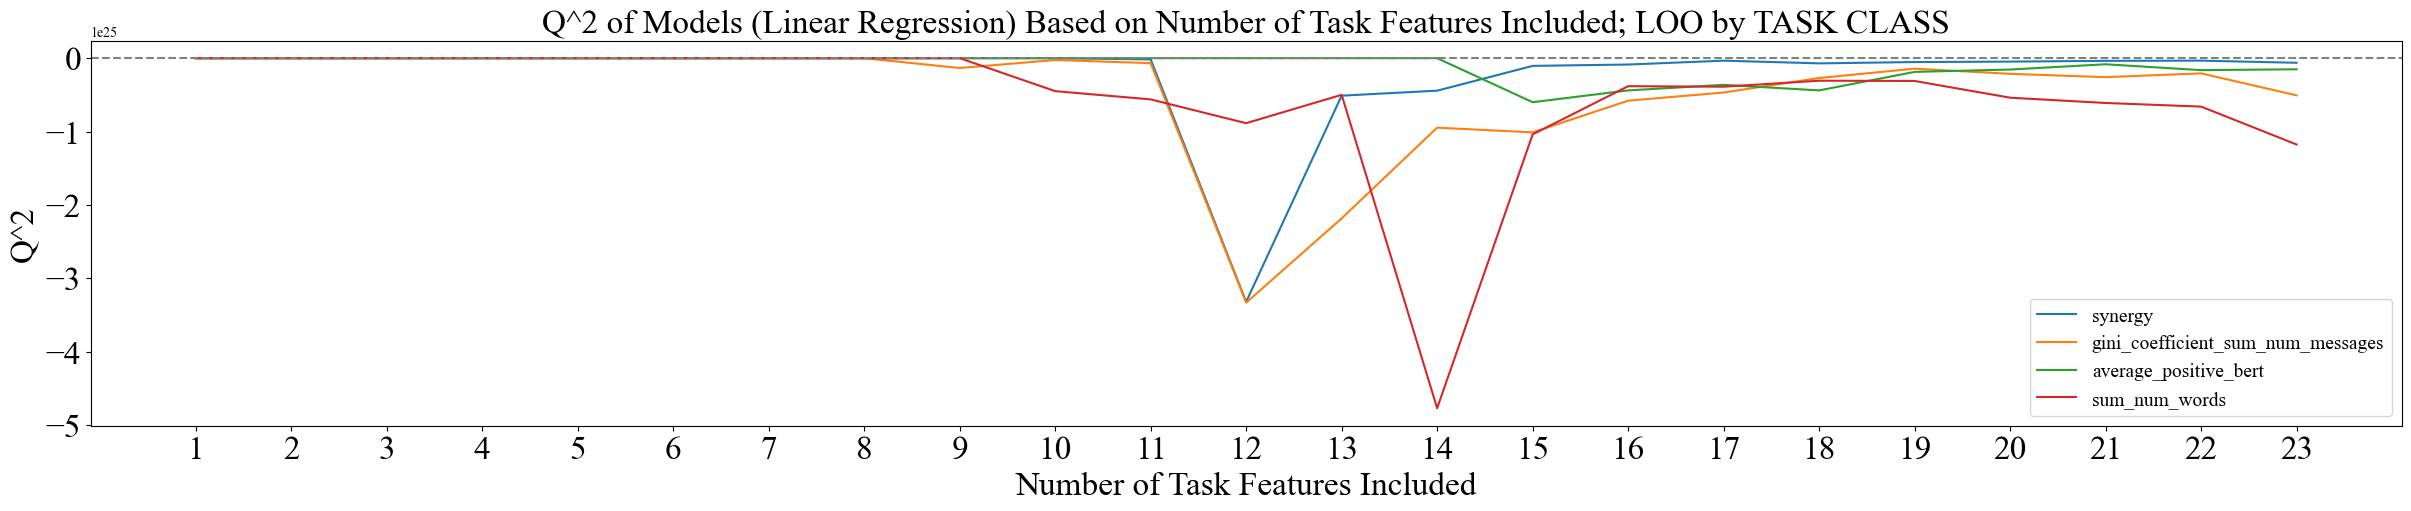

In [60]:
plot_q2_by_number_of_features(df_q2_means_for_feature, 'Q^2 of Models (Linear Regression) Based on Number of Task Features Included; LOO by TASK CLASS')

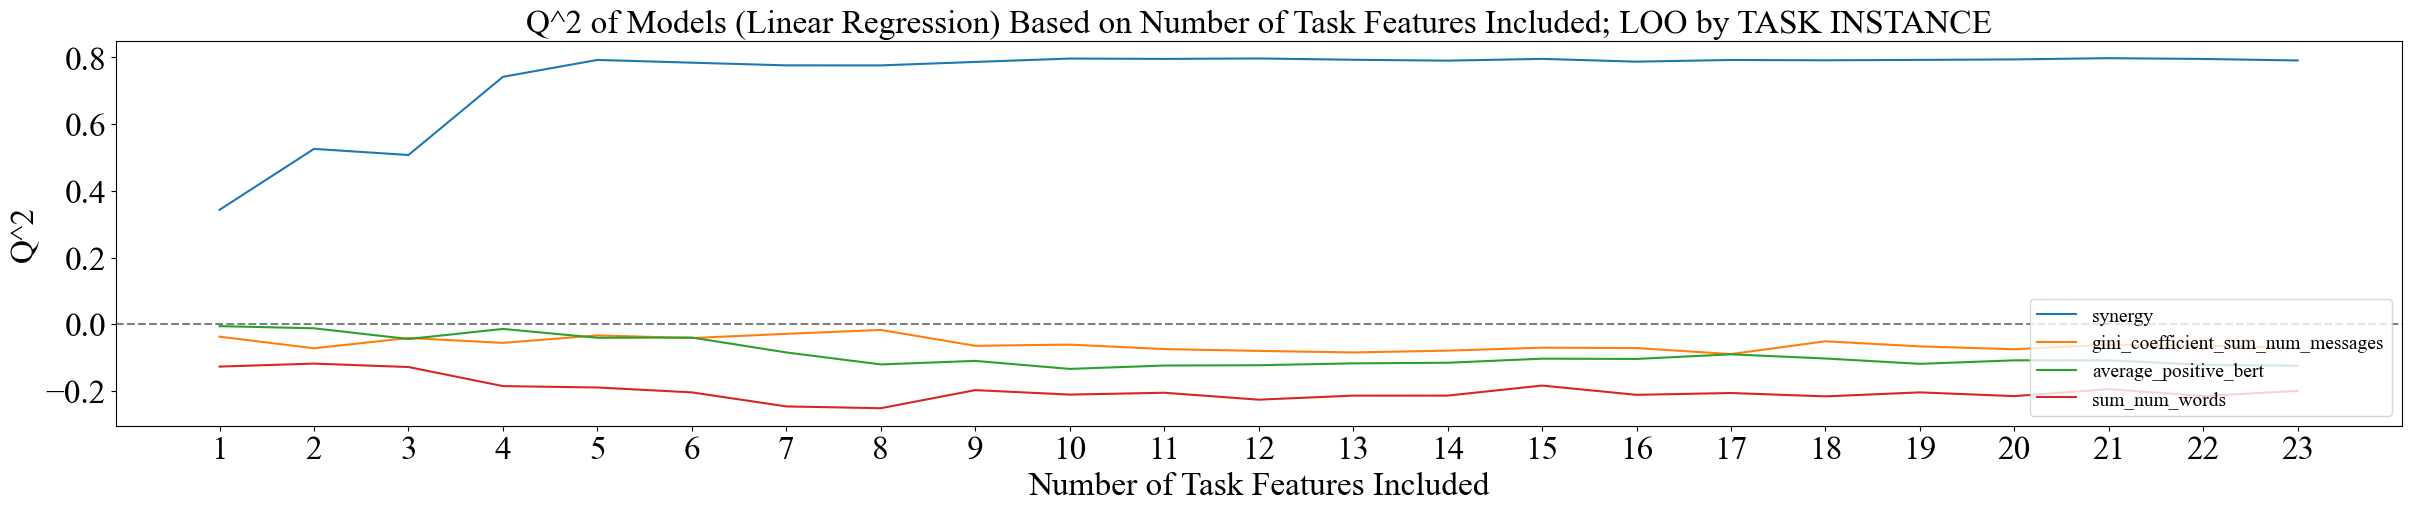

In [61]:
plot_q2_by_number_of_features(df_q2_means_for_feature_instance, 'Q^2 of Models (Linear Regression) Based on Number of Task Features Included; LOO by TASK INSTANCE')

# "Us versus McGrath" Analysis

### Comparison of Moral Reasoning to Allocating Resources to Programs

In [62]:
mcgrath_colnames = [col for col in task_map.columns if "type" in col]

In [63]:
allocating_moral = task_map[(task_map["task_name"]=="Moral Reasoning (Disciplinary Action Case)") | (task_map["task_name"]=="Allocating resources to programs")]
allocating_moral

,task_name,Q1concept_behav,Q3type_1_planning,Q4type_2_generate,Q6type_5_cc,Q7type_7_battle,Q8type_8_performance,Q9divisible_unitary,Q10maximizing,Q11optimizing,...,Q18ans_recog,Q19time_solvability,Q20type_3_type_4,Q22confl_tradeoffs,Q23ss_out_uncert,Q24eureka_question,Q2intel_manip_1,Q21intellective_judg_1,Q5creativity_input_1,Q25_type6_mixed_motive
10,Moral Reasoning (Disciplinary Action Case),0.0,0.12,0.24,0.88,0.00,0.16,0.166667,0.00,0.08,...,0.080000,0.125000,0.04,1.00,0.571429,0.0,0.012,0.108,0.404,0
22,Allocating resources to programs,0.0,0.44,0.36,1.00,0.04,0.00,0.240000,0.16,0.16,...,0.086957,0.166667,0.08,0.96,0.360000,0.0,0.036,0.196,0.480,0


Key differences on other dimensions

- **Q3type_1_planning**: Is this a "planning" task? In other words, is one of the main purpose(s) of this task to produce a sequence of concrete steps or actions that an individual can follow to achieve some goal?
- **Q23ss_out_uncert**: When doing this task, will the participants have any uncertainty about whether their method or solution will lead to the desired outcome?
- **Q8type_8_performance**: Does the task have an all-or-nothing outcome? In other words, is it sufficient to just meet a particular standard?
- **Q10maximizing** Is the goal (or one of the goals) of this task to try to achieve doing something as much as possible, as many as possible, or as quickly as possible?

In [64]:
# difference between rows
(allocating_moral.iloc[0][1:] - allocating_moral.iloc[1][1:]).sort_values(key=abs, ascending=False)

Q3type_1_planning            -0.32
Q23ss_out_uncert          0.211429
Q8type_8_performance          0.16
Q10maximizing                -0.16
Q17within_sys_sol         0.144348
Q4type_2_generate            -0.12
Q6type_5_cc                  -0.12
Q21intellective_judg_1      -0.088
Q11optimizing                -0.08
Q5creativity_input_1        -0.076
Q9divisible_unitary      -0.073333
Q19time_solvability      -0.041667
Q22confl_tradeoffs            0.04
Q16shared_knowledge          -0.04
Q20type_3_type_4             -0.04
Q14sol_scheme_mul             0.04
Q15dec_verifiability         -0.04
Q13outcome_multip             0.04
Q7type_7_battle              -0.04
Q2intel_manip_1             -0.024
Q18ans_recog             -0.006957
Q1concept_behav                0.0
Q24eureka_question             0.0
Q25_type6_mixed_motive           0
dtype: object

In [65]:
# here's how these two tasks look across all mcGrath columns
allocating_moral[["task_name"] + mcgrath_colnames]

,task_name,Q3type_1_planning,Q4type_2_generate,Q6type_5_cc,Q7type_7_battle,Q8type_8_performance,Q20type_3_type_4,Q25_type6_mixed_motive
10,Moral Reasoning (Disciplinary Action Case),0.12,0.24,0.88,0.00,0.16,0.04,0
22,Allocating resources to programs,0.44,0.36,1.00,0.04,0.00,0.08,0


In [66]:
allocation_moral_mcgrath = allocating_moral[["task_name"] + mcgrath_colnames]

# both of them would be considered Type 5 (Cognitive Conflict)
for i in range(len(allocation_moral_mcgrath)):
    task_vec_mcgrath = allocation_moral_mcgrath.iloc[0][1:]
    print(task_vec_mcgrath.idxmax())

Q6type_5_cc
Q6type_5_cc


In [67]:
# look at some dv's
stage_based_data.dvs.groupby("task").agg("mean").reset_index()

,task,score,speed,efficiency,raw_duration_min,default_duration_min
0,Allocating Resources,64.913793,6.900158,580.312341,2.811993,3.0
1,Divergent Association,90.495483,2.968898,261.945100,2.926658,3.0
2,Guess the Correlation,74.100000,12.840271,999.382531,1.755870,2.0
3,Moral Reasoning,62.500000,11.465764,543.279689,4.437569,5.0
4,Room Assignment,87.202917,20.785565,1916.361707,3.975902,5.0
5,Sudoku,78.711864,13.914606,1362.684040,4.319687,5.0
6,Whac a Mole,36.986985,0.000833,0.030822,2.039582,2.0
7,Wolf Goat Cabbage,89.232558,37.690484,3553.012074,3.124047,5.0
8,Word Construction,48.679104,0.550313,14.557094,3.006662,3.0
9,Writing Story,92.548501,6.152556,493.377618,4.709141,5.0


In [68]:
stage_based_data.data.groupby(["task_name"])[["gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_messages", "sum_num_words"]].agg("mean").reset_index().sort_values("sum_num_messages")

,task_name,gini_coefficient_sum_num_messages,average_positive_bert,sum_num_messages,sum_num_words
6,Whac-A-Mole,0.034503,0.224990,2.368421,12.263158
8,Word construction from a subset of letters,0.068284,0.213040,2.892308,14.107692
1,Divergent Association Task,0.114491,0.262374,5.298851,25.264368
5,Sudoku,0.152894,0.319589,7.483051,37.220339
0,Allocating resources to programs,0.153544,0.258275,7.836207,50.474138
2,Guessing the correlation,0.163716,0.241361,8.376923,37.407692
9,Writing story,0.168322,0.268186,9.738095,84.531746
7,"Wolf, goat and cabbage transfer",0.170308,0.295378,10.170543,47.333333
4,Room assignment task,0.182873,0.348978,10.967480,48.455285
3,Moral Reasoning (Disciplinary Action Case),0.186328,0.216987,12.400000,92.976923


### How much do we predict, versus how much McGrath alone predicts?

In [69]:
# remove type 6, as it is not relevant for our data
mcgrath_colnames.remove('Q25_type6_mixed_motive')

In [70]:
mcgrath_colnames

['Q3type_1_planning',
 'Q4type_2_generate',
 'Q6type_5_cc',
 'Q7type_7_battle',
 'Q8type_8_performance',
 'Q20type_3_type_4']

In [71]:
# let's do this for a single mcgrath bucket
mcgrath_categorical_buckets = {}

for i in range(len(grouped_performance_with_task_cols)):
    task_vec_mcgrath = grouped_performance_with_task_cols[mcgrath_colnames].iloc[i][1:]
    task_name = grouped_performance_with_task_cols.iloc[i]["task_name"]
    task_type = task_vec_mcgrath.idxmax()
    type_val = task_vec_mcgrath[task_type]
    if task_type == "Q20type_3_type_4":
        task_type = "type_3_intellective" if type_val > 0.5 else "type_4_decision_making"

    mcgrath_categorical_buckets[task_name] = task_type

In [72]:
# TODO --- still verify these with manual categorical classification
mcgrath_categorical_buckets

{'Allocating resources to programs': 'Q6type_5_cc',
 'Divergent Association Task': 'Q4type_2_generate',
 'Guessing the correlation': 'type_3_intellective',
 'Moral Reasoning (Disciplinary Action Case)': 'Q6type_5_cc',
 'Room assignment task': 'type_3_intellective',
 'Sudoku': 'type_3_intellective',
 'Whac-A-Mole': 'type_4_decision_making',
 'Wolf, goat and cabbage transfer': 'type_3_intellective',
 'Word construction from a subset of letters': 'Q4type_2_generate',
 'Writing story': 'Q4type_2_generate'}

In [73]:
# by manual inspection, this one is wrong
mcgrath_categorical_buckets["Writing story"] = "Q8type_8_performance"

In [74]:
mcgrath_df = pd.DataFrame({
    "task_name": mcgrath_categorical_buckets.keys(),
    "mcgrath_category": mcgrath_categorical_buckets.values()
})

mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)

In [75]:
aggregated_performance_by_task = grouped_performance_with_task_cols.merge(mcgrath_df_categorical, on = "task_name")

In [76]:
mcgrath_categorical = [col for col in aggregated_performance_by_task.columns if "_cat" in col]

### Compare the Q^2 we get to the Q^2 McGrath gets

In [78]:
dvs = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]

# this is LOO by TASK CLASS
dv_output_dict_comparison = {}
for dv in dvs:
    dv_output_dict_comparison[dv] = {}
    dv_output_dict_comparison[dv]["mcgrath_continuous"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[mcgrath_colnames + ["playerCount", "Low", "Medium"]])
    dv_output_dict_comparison[dv]["mcgrath_categorical"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[mcgrath_categorical + ["playerCount", "Low", "Medium"]])
    dv_output_dict_comparison[dv]["all_features"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[list(task_cols_to_use) + ["playerCount", "Low", "Medium"]])

# this is LOO by TASK INSTANCE
dv_output_dict_comparison_instance = {}
for dv in dvs:
    dv_output_dict_comparison_instance[dv] = {}
    dv_output_dict_comparison_instance[dv]["mcgrath_continuous"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[mcgrath_colnames + ["playerCount", "Low", "Medium"]], unit = "instance")
    dv_output_dict_comparison_instance[dv]["mcgrath_categorical"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[mcgrath_categorical + ["playerCount", "Low", "Medium"]], unit = "instance")
    dv_output_dict_comparison_instance[dv]["all_features"] = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[list(task_cols_to_use) + ["playerCount", "Low", "Medium"]], unit = "instance")

> I think we should stick to the categorical version since it’s the closest to what he described in his paper (mutually exclusive and collectively exhaustive)… We can either omit or rename the continuous McGrath to something like “Task Space: McGrath’s subspace” (or another name like “sask space: McGrath-inspired subspace” or “mcgrath-derived task dimensions”) to say that this lift in performance is not because of McGrath but mostly because of all the work we’ve done to dimensionalize it, rate it, etc.

In [79]:
pd.DataFrame(dv_output_dict_comparison)

,synergy,gini_coefficient_sum_num_messages,average_positive_bert,sum_num_words
mcgrath_continuous,3.657029e-02,-1.434816e-01,-3.525749e-01,-2.106411e-01
mcgrath_categorical,9.899554e-02,-1.006144e-01,8.431192e-02,-4.346650e-02
all_features,-4.207979e+24,-5.775210e+25,-2.666507e+25,-1.731101e+26


In [80]:
pd.DataFrame(dv_output_dict_comparison_instance)

,synergy,gini_coefficient_sum_num_messages,average_positive_bert,sum_num_words
mcgrath_continuous,0.733156,-0.010955,-0.060831,-0.180573
mcgrath_categorical,0.676888,-0.128771,-0.050716,-0.165220
all_features,0.789874,-0.060268,-0.110843,-0.211114


# Q^2 Plot by Number of Tasks
This is done on the TASK CLASS LEVEL.

In [87]:
tasks_unique = list(grouped_performance_with_task_cols["task_name"].drop_duplicates())

In [88]:
if("complexity" in GROUPING_COLS and "playerCount" in GROUPING_COLS):

    dvs = ["synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
    q2_by_task_output_dict = {}
    q2_by_task_instance_output_dict = {}

    for i, dv in enumerate(dvs):
        q2_by_task_output_dict[dv] = {}
        q2_by_task_instance_output_dict[dv] = {}

        for num_tasks in range(1, len(tasks_unique)):
            print("Now running models for " + str(num_tasks) + " tasks...")
            q2_by_task_output_dict[dv][str(num_tasks)] = []
            q2_by_task_instance_output_dict[dv][str(num_tasks)] = []

            ### For holding out a FULL TASK

            # here is a learning curve for a single feature in linear regression
            # top_feature = top_n_q2_for_index(dv, 1)[0]
            # q2 = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[[top_feature, "playerCount", "Low", "Medium"]], num_task_holdouts=len(tasks_unique)-num_tasks)

            # here is the linear version of q2
            q2 = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[list(task_cols_to_use) + ["playerCount", "Low", "Medium"]], num_task_holdouts=len(tasks_unique)-num_tasks)
            q2_by_task_output_dict[dv][str(num_tasks)].append(q2)

            #### For holding out a TASK INSTANCE
            q2 = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[list(task_cols_to_use) + ["playerCount", "Low", "Medium"]], num_task_holdouts=len(tasks_unique)-num_tasks, unit = "instance")
            q2_by_task_instance_output_dict[dv][str(num_tasks)].append(q2)

Now running models for 1 tasks...
Now running models for 2 tasks...
Now running models for 3 tasks...
Now running models for 4 tasks...
Now running models for 5 tasks...
Now running models for 6 tasks...
Now running models for 7 tasks...
Now running models for 8 tasks...
Now running models for 9 tasks...
Now running models for 1 tasks...
Now running models for 2 tasks...
Now running models for 3 tasks...
Now running models for 4 tasks...
Now running models for 5 tasks...
Now running models for 6 tasks...
Now running models for 7 tasks...
Now running models for 8 tasks...
Now running models for 9 tasks...
Now running models for 1 tasks...
Now running models for 2 tasks...
Now running models for 3 tasks...
Now running models for 4 tasks...
Now running models for 5 tasks...
Now running models for 6 tasks...
Now running models for 7 tasks...
Now running models for 8 tasks...
Now running models for 9 tasks...
Now running models for 1 tasks...
Now running models for 2 tasks...
Now running mo

In [89]:
df_q2_means_for_task = pd.DataFrame()
for key in q2_by_task_output_dict.keys():
    means = [np.mean(sublist) for sublist in q2_by_task_output_dict[key].values()]
    df_q2_means_for_task[key] = means

df_q2_means_for_task_instance = pd.DataFrame()
for key in q2_by_task_instance_output_dict.keys():
    means = [np.mean(sublist) for sublist in q2_by_task_instance_output_dict[key].values()]
    df_q2_means_for_task_instance[key] = means

# df_q2_stds_for_task = pd.DataFrame()
# for key in q2_by_task_output_dict.keys():
#     std = [np.std(sublist) for sublist in q2_by_task_output_dict[key].values()]
#     df_q2_stds_for_task[key] = std

In [90]:
def plot_performance_by_number_of_tasks(df_q2_means_for_task, title):
    fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

    width = 0.16  # the width of the bars
    multiplier = 0

    dv_colors = {}

    for dv in df_q2_means_for_task.columns:
        means_for_key = df_q2_means_for_task[dv]
        # stds_for_key = df_q2_stds_for_task[dv]
        # line plot version
        line, = ax.plot(np.arange(1, len(tasks_unique)), means_for_key, label=f'{dv}')
        dv_colors[dv] = line.get_color()  # Store the color for this DV
        # bar plot version
        # rects = ax.bar(np.arange(1, len(tasks_unique)) + offset - offset_back, means_for_key, width, label=f'{dv}')
        # for i in range(1, len(tasks_unique)):
        #     x = i
        #     y = means_for_key[i-1]
        #     # std = stds_for_key[i-1]
        #     ax.errorbar(x, y, std, color="black")
        # multiplier += 1

    ax.legend(fontsize=14, loc='lower right')
    plt.xticks(ticks=[_ for _ in range(1, len(tasks_unique))], fontsize=24)
    plt.xlabel('Number of Tasks Trained On', fontsize=24)

    # yticks = np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 0.1, 0.1)
    # yticks = np.unique(np.concatenate((yticks, np.round(yticks))))
    # yticklabels = [f'{round(tick, 1)}' if round(tick, 1) == tick else '' for tick in yticks]
    # plt.yticks(yticks, yticklabels, fontsize=24)

    # Adding horizontal gray line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

    # Adding lines for optimal performance
    # TODO --- this needs to be redone based on the task class holdout scheme
    # for dv in df_q2_means_for_feature.columns:
    #     optimal_df = pd.DataFrame(optimal_dict)
    #     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
    #     best_perf = np.max(performance_for_dv["optimal_q2"])
    #     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

    plt.ylabel('Q^2', fontsize=24)
    plt.title(title, fontsize=24)

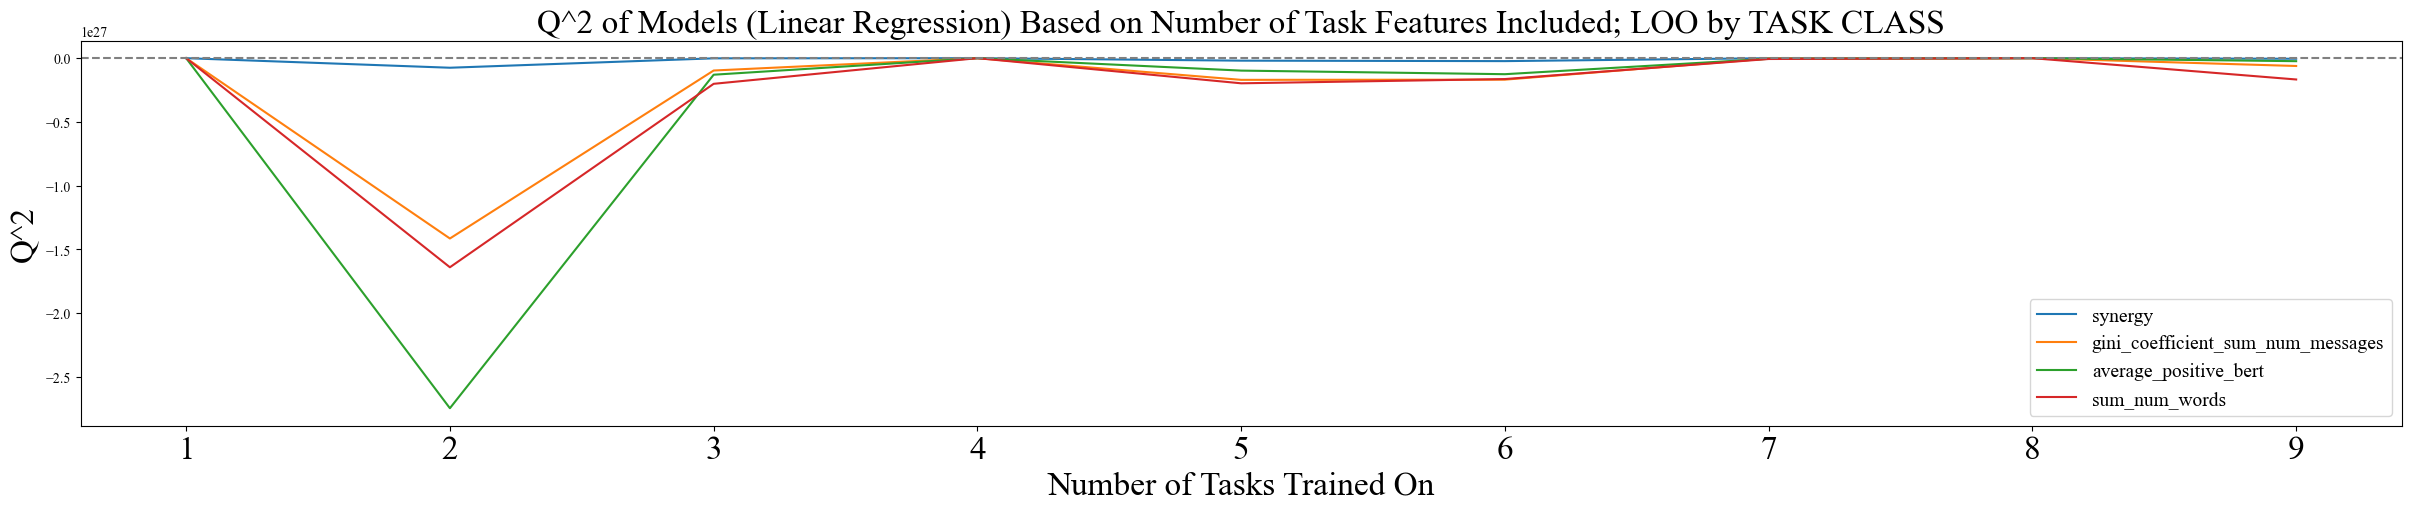

In [91]:
plot_performance_by_number_of_tasks(df_q2_means_for_task, "Q^2 of Models (Linear Regression) Based on Number of Task Features Included; LOO by TASK CLASS")

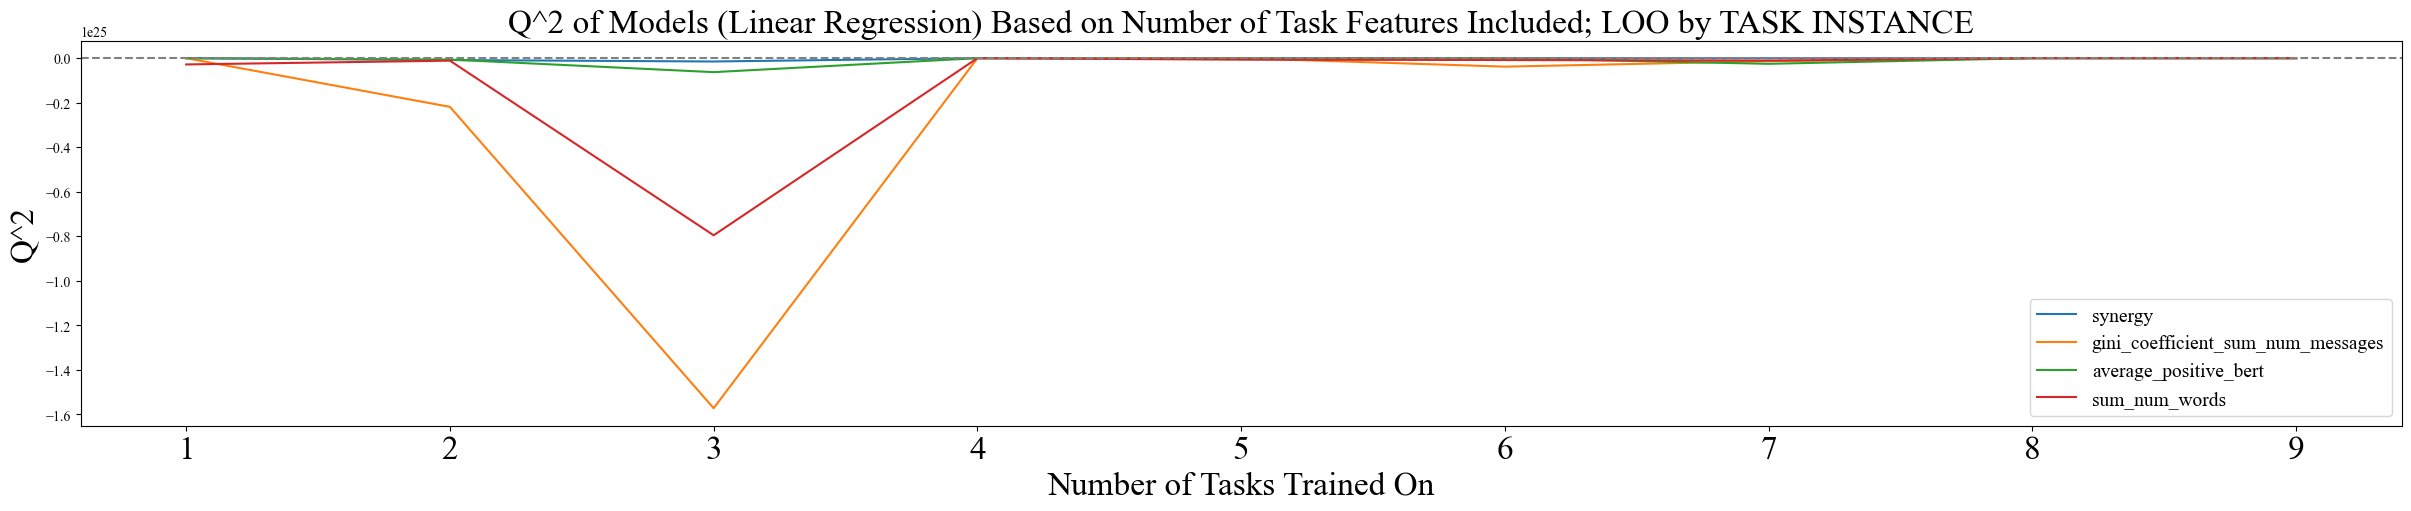

In [92]:
plot_performance_by_number_of_tasks(df_q2_means_for_task_instance, "Q^2 of Models (Linear Regression) Based on Number of Task Features Included; LOO by TASK INSTANCE")

# Parallel Coordinates Plot

In [93]:
# select whether we want the task ranking or the instance ranking
q2_by_dv_df = q2_by_dv_df_task # q2_by_dv_df_instance 

In [94]:
q2_by_dv_plot = q2_by_dv_df.copy()

# set up a dictionary to track the top feature
top_dict = {
    "dv": list(q2_by_dv_plot.index)
}
for i in range(1, len(q2_by_dv_plot.columns)+1):
    colname = "top_" + str(i)
    top_dict[colname] = []

for dv, row in q2_by_dv_plot.iterrows():

    new_rows = pd.DataFrame()

    for i in range(1, len(q2_by_dv_plot.columns)+1):
        nth_col = row.nlargest(i).index.tolist()[-1]
        colname = "top_" + str(i)

        top_dict[colname].append(nth_col)

In [95]:
progressive_feature_by_q2 = pd.DataFrame(top_dict)

In [96]:
progressive_features_by_dv = progressive_feature_by_q2.T
progressive_features_by_dv.columns = progressive_features_by_dv.iloc[0].values
progressive_features_by_dv.drop('dv', inplace=True)
progressive_features_by_dv = progressive_features_by_dv.reset_index()
progressive_features_by_dv = progressive_features_by_dv.drop("index", axis = 1)

In [97]:
# reorder
progressive_features_by_dv = progressive_features_by_dv.reindex(columns=['synergy', 'gini_coefficient_sum_num_messages',
       'sum_num_words', 'average_positive_bert'])

In [98]:
ranked_data = {key: {value: i+1 for i, value in enumerate(progressive_features_by_dv[key])} for key in progressive_features_by_dv}

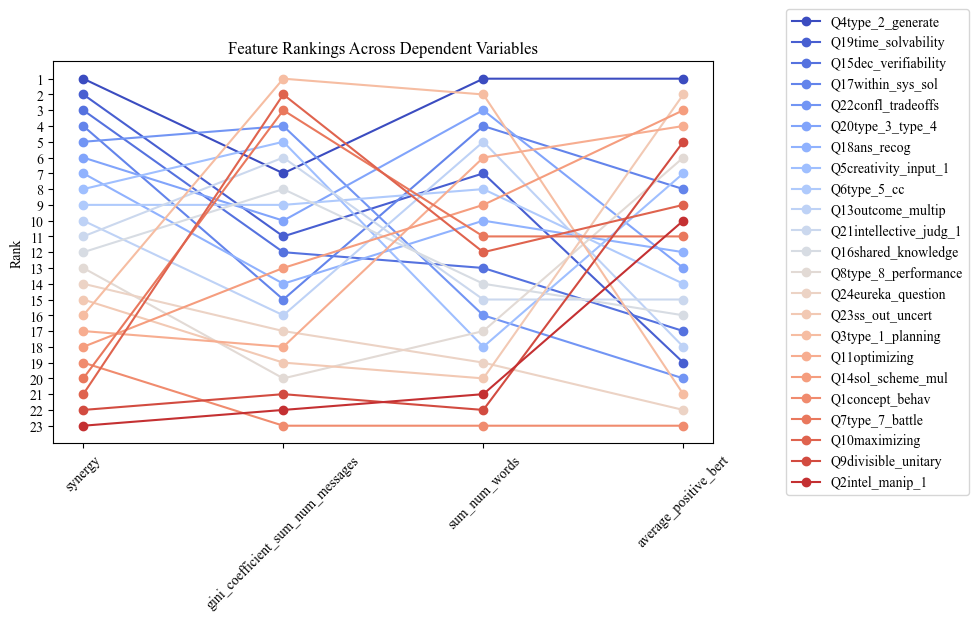

In [99]:
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i/len(ranked_data['synergy'])) for i in range(len(ranked_data['synergy']))]

# Plotting
plt.figure(figsize=(10, 6))

for i, feature in enumerate(ranked_data['synergy']):
    plt.plot(list(ranked_data.keys()), [ranked_data[dv][feature] for dv in ranked_data], marker='o', label=feature, color=colors[i])

plt.xticks(rotation=45)
plt.ylabel('Rank')
plt.title('Feature Rankings Across Dependent Variables')
plt.gca().invert_yaxis()  # Reverse y-axis
plt.yticks(range(1, 24))  # Set y-axis ticks from 1 to 23
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))  # Move legend to the right
plt.tight_layout()
plt.show()